## Operating a fleet of aircrafts with RL: How to use the Environment?

This notebook describes how to use the environment implemented in `opfleet_env.py` and describes the different methods and functionalities of the environment. 

The aim is to use this setup to demonstrate that RL can be used to optimise the operation and management of a fleet of aircrafts (mission assignment + maintenance scheduling).
#### To install

To install the necessary python libraries, open the Anaconda Prompt, drive to the directory where the `environment.yml` file is and run the following command:

`conda env create -f environment.yml -n rlenv`

This will create a virtual environment with all the required packages (tensorflow, pytorch, gym etc...). Then activate the environment with `conda activate rlenv`.
#### Initial settings

In [52]:
import os
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import time
import copy

# plotting parameters
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# import environment module
import opfleet_env as opfleet

### 1. The Env class

The `Env` class contains the gym-like environment for the fleet of aircraft.

The environment is initialised by providing a set of customisable parameters in the `params` dictionnary.

In this section we show the different options in the `params` dictionnary.

For example let's create an environment with:
- a 4-aircraft fleet wuth 2 mission types (M1 and M5)
- 4 missions prescribed missions per day, two of each type
- lifetime of 5 years (2018-2023)
- reward of +1 for M1 and +2 for M5
- penalty of -10 for preventive maintenance and -100 for corrective maintenance and 5 timesteps of waiting period in both cases
- crack length discretised in 10 levels

In [8]:
params = {

    # Paris law parameters for degradation model
    'b': 76.2/1000,         # body width converted to metres
    'm': 2.9,               # Paris exponent
    'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
    'C_std': 3*0.619e-11,     # std of Paris coefficient C 

    # initial and critical crack length
     'a0': 9/1000,          # 9mm as in Virkler data converted to metres
     'amax': (76.2/2)/1000, # critical at one third of body width

    # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
    'f0': 5,

    # assume that different maneuvers have different stress range (ds)
    # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
    # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
    # maneuver m3: ds = 70 MPa (barrel rotate)
    # maneuver m4: ds = 90 MPa (pull up/down & turn)
    # maneuver m5: ds = 110 MPa (vertical up/down)
    'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver

    # define 5 types of missions, where different maneuvers are performed
    # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
    # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
    # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
    # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
    # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
    # duration in s:      M1, M2, M3, M4, M5
    'missions': {'M1': [2600, 60, 30, 0 , 10],
                 'M5': [4500, 60, 0 , 60, 80]},    

    # fleet composition
    'n_tail': 4, 

    # episode timeframe (Monday to Friday)
    'date_start': datetime(2018,1,1),   # starting date
    'date_end': datetime(2023,1,1),     # ending date

    # prescribed missions, number of daily missions and composition
    'missions_per_day': 4,              # how many missions are prescribed each day
    'mission_composition': 'fixed-constant',  # 3 options for the mission composition:
                                        # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                        # 'fixed-constant-random': if more missions than mission types, chooses the extra missions randomly
                                        # 'fixed-mixed': fixed number of missions but random composition  
                                        # 'random': random number of missions and random composition 
                                        # 'custom': provide a mission composition that is repeated for every day

    # reward function [-1 per day in maintenance, 0 standby]
    'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                 # 'constant': constant reward [+1 per mission flown]
                                 # 'damage-based': reward based on damage caused
                                 # 'mission-based': reward based on mission type
    # if 'mission-based', specify the rewards
    'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

    # maintenance levels      duration repair   cost
    'preventive_maintenance': [5,      30,     10],
    'corrective_maintenance': [5,     30,      100],

    # crack length discretation
    'damage_levels': 10,
    
    }
print(params)

{'b': 0.0762, 'm': 2.9, 'C_median': 9.824e-11, 'C_std': 1.857e-11, 'a0': 0.009, 'amax': 0.0381, 'f0': 5, 'maneuvers': [30, 50, 70, 90, 110], 'missions': {'M1': [2600, 60, 30, 0, 10], 'M5': [4500, 60, 0, 60, 80]}, 'n_tail': 4, 'date_start': datetime.datetime(2018, 1, 1, 0, 0), 'date_end': datetime.datetime(2023, 1, 1, 0, 0), 'missions_per_day': 4, 'mission_composition': 'fixed-constant', 'reward_scheme': 'mission-based', 'reward_per_mission': [1, 2], 'preventive_maintenance': [5, 30, 10], 'corrective_maintenance': [5, 30, 100], 'damage_levels': 10}


A C-value (Paris coefficient) is randomly assigned to each aircraft in the fleet

In [9]:
# randomly generate the C-values for each aircraft in the fleet
params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
print(params['C'])

[1.11505288e-10 9.18387088e-11 8.45982171e-11 1.14034307e-10]


Then we can initialise one instance and we see the prescribed missions as well as a summary of the environment created.

5220 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 4
Number of actions per tail number: 4
['M1', 'M5', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 256
Number of possible states: 6561


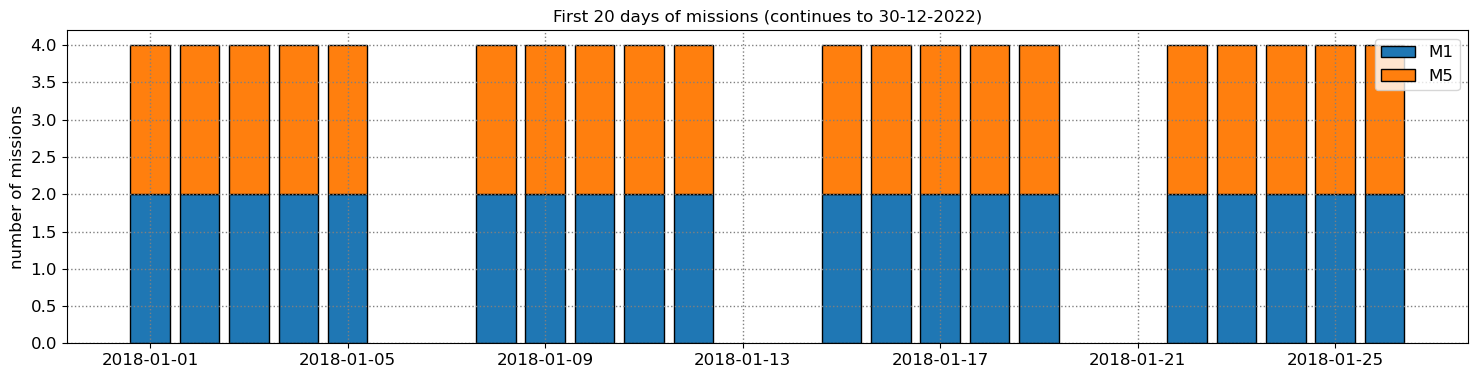

In [10]:
# initialise environment, by setting verbose = True we get a summary of the env
env = opfleet.Env(params, verbose=True)

### 2. Mission composition

We can play with the `mission_composition` parameter to include some randomness in the mission generator.

5220 missions generated from 01-01-2018 to 30-12-2022 (1305 days)


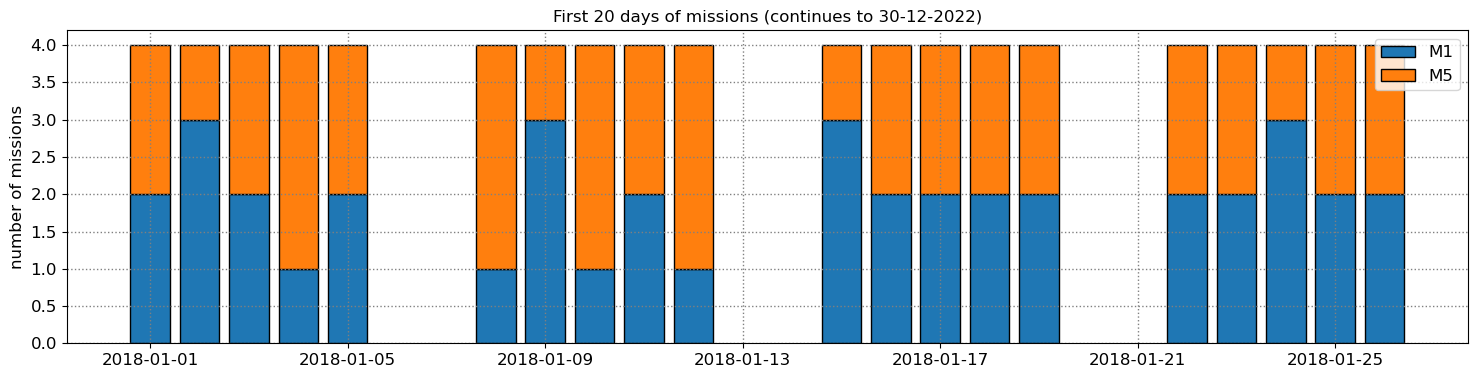

In [19]:
# change mission composition to fixed random
params['mission_composition'] = 'fixed-mixed'
env.create_mission_profile(params, verbose=True);

4908 missions generated from 01-01-2018 to 30-12-2022 (1305 days)


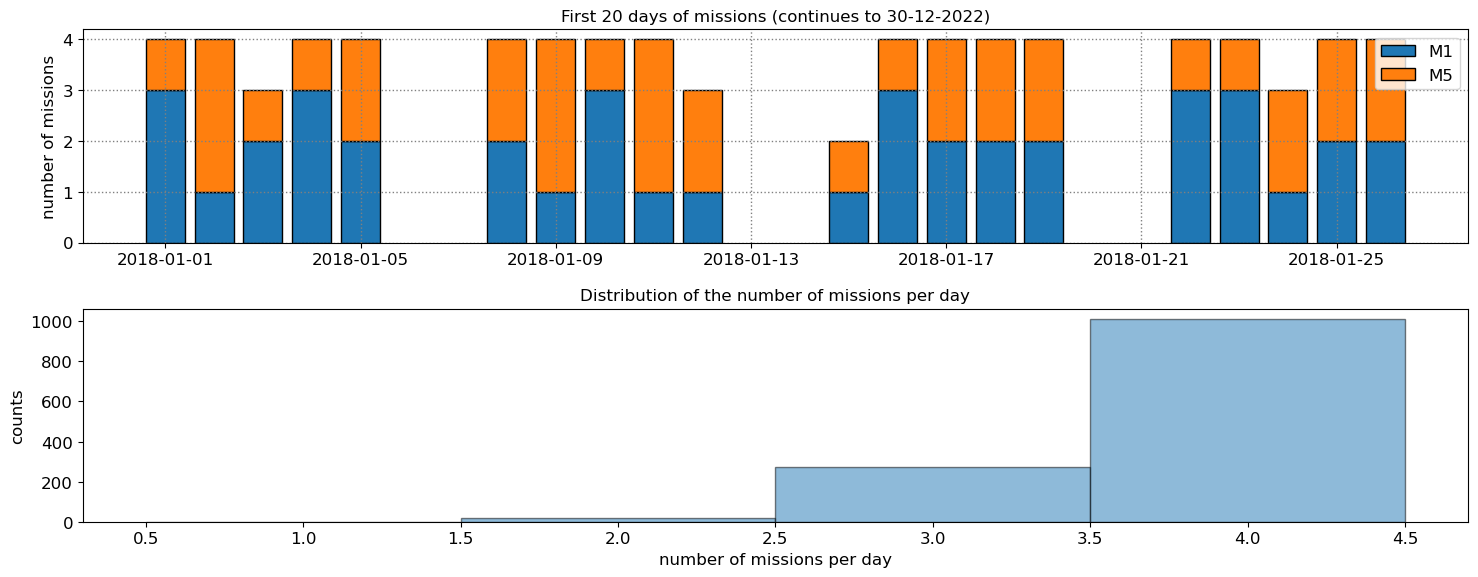

In [20]:
# change mission composition to random (also the number of missions per day is randomly generated)
params['mission_composition'] = 'random'
env.create_mission_profile(params, verbose=True);

Or set a custom set of prescribed missions:

5220 missions generated from 01-01-2018 to 30-12-2022 (1305 days)


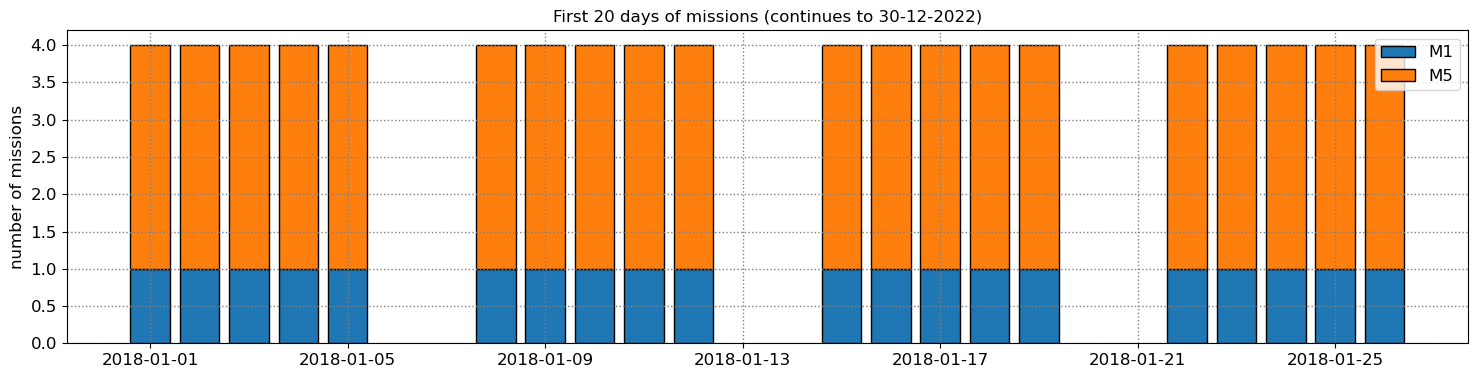

In [22]:
# change mission composition to custom (1 M1 and 3 M5)
params['mission_composition'] = 'custom'
params['custom_missions'] = [1,3]
env.create_mission_profile(params, verbose=True);

### 3. The reward function
The agent or operator receives positive rewards when missions are completed, and negative rewards for stand-by or maintenance. The reward and penalties given are arbitrary and can be defined with the `params` dictionnary, using the `reward_scheme`, `reward_per_mission`, `preventive_maintenance` and `corrective_maintenance` fields. In any case, the reward/cost for the stand-by action is hard-coded to -1.


### 4. The degradation model
The degradation model follows a Paris law that was calibrated to fit the Virkler experiment, therefore the default values should be kept constant (`b`,`m`,`C_median`,`C_std`,`a0` and `amax`). 

The only parameter that can be tinkered with is the cyclic stress frequency `f0` (20Hz in Virkler experiment). We have set it to 5 Hz as this was found to provide a reasonable propagation speed so that about 10 maintenance cycles a year could be observed.

The discretisation level `damage_levels` was set to 10 arbitrarily. This actually corresponds to 9 observable states as the failure state is never observed since corrective maintenance is applied automatically if an aircraft fails during operation.

C-values for the tail numbers:
[1.11505288e-10 9.18387088e-11 8.45982171e-11 1.14034307e-10]
using provided C values


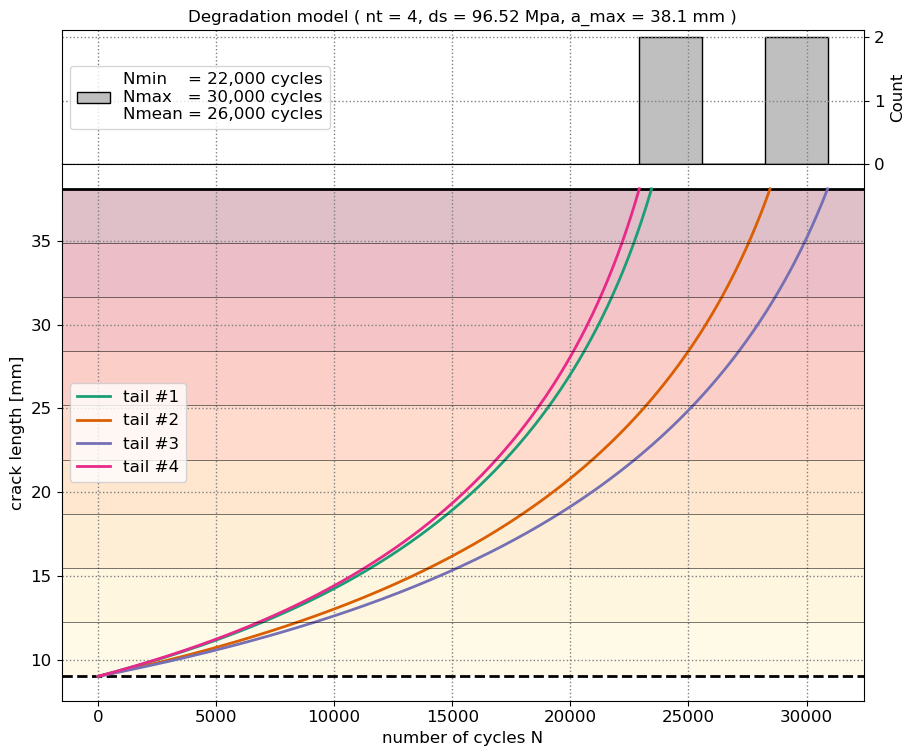

In [24]:
print('C-values for the tail numbers:'); print(params['C'])
ds = 48.26*2                # stress range in MPa, depends on manoeuvre
nt = 68*3                   # number of trajectories
a_max = 76.2/2              # maximum crack length allowable in mm

N, N_min, a, C, fig = opfleet.degradation_model(ds,nt,a_max,2,C=params['C'],
                                                levels=params['damage_levels'])

### 5. The Env methods step(), reset(), fleet_status()

We have already seen one of the methods of the Env class when we called `env.create_mission_profile(params)`, this method is only ran once at the start to generate the prescribed missions. When using the environment the key methods are:
- `env.step(action)`: it is used to transition into the next state based on the action selected and return a reward.
- `env.reset(regenerate_missions=False)`: resets the environment to timestep 0 (important when starting a new episode). There is the option to keep the same missions or generate new ones (regenerate_missions=True).
- `env.fleet_status()`: plots the current state of the fleet to keep track of how the environment works

Let's look at an example, here we select action [0,1,1,1] which is to assign M1 to tail#1 and M5 to the other tails. A reward of 7 is obtained and the aircraft crack length is propagated, although they remain within the same damage level bin.

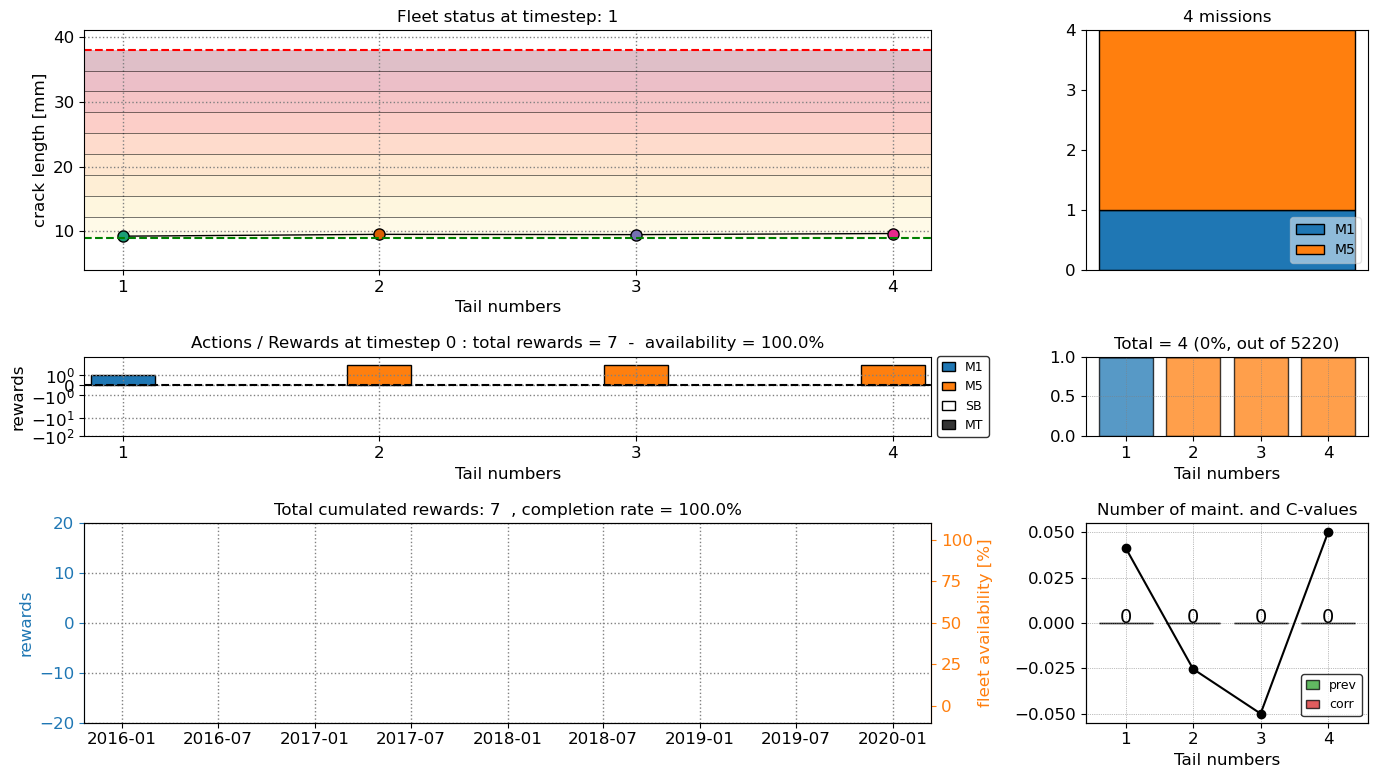

In [30]:
env = opfleet.Env(params) # initialise envrionment
action = [0,1,1,1]
env.step(action)
fig = env.fleet_status()

Now we can run this same action for 10 timesteps

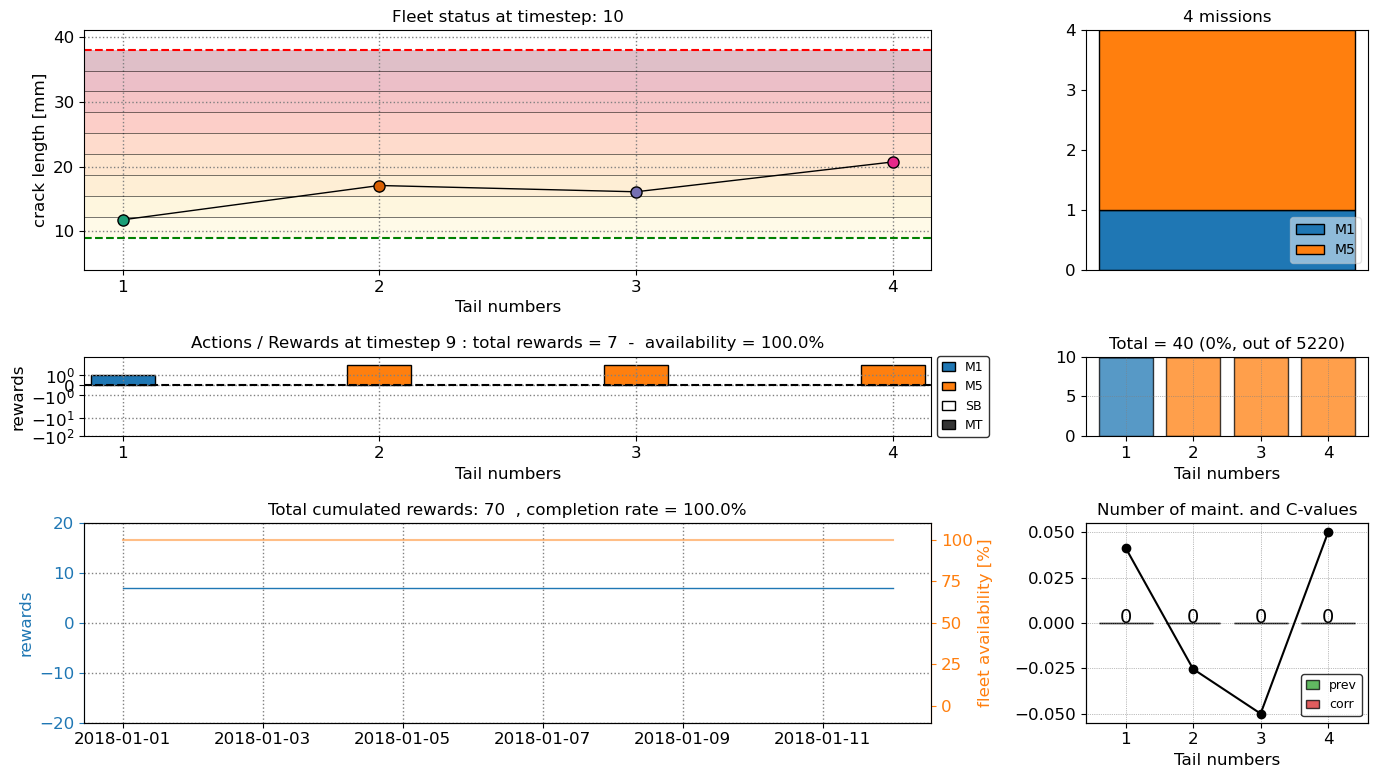

In [33]:
action = [0,1,1,1]
env.reset()
for i in range(10):
    env.step(action)
fig = env.fleet_status()

### 6. Baseline policies

We have also coded up some baseline policies that can be used to run a full episode:
- random policy: `episode_random()`, just selects random actions
- on-condition maintenance: `episode_on_condition(maint_level)`, applies maintenance when the maint_level is reached, otherwise it assigns missions randomly
- force-life management: `episode_force_life(maint_level)`, applies maintenance when the maint_level is reached, otherwise it assigns missions so that the cumulated crack length is kept constant across the fleet.
- equal-stress policy: `episode_equal_stress(maint_level)`, applies maintenance when the maint_level is reached, otherwise it assigns missions so that the theoretical stress range is kept constant across the fleet (does not assume knowledge of the C-values and crack length, just the mission stress range and duration).

In all cases, it is possible to visualise each timestep of the policy by setting the parameter `plot_steps=True`, `N=number of timesteps` and `fp=directory in which to save the figures`.

Once an episode is completed with the functions above, we can use the `plot_episode(damage_ts,reward_ts,env)` to plot a summary of how the episode went. 

random -> total rewards = -8091


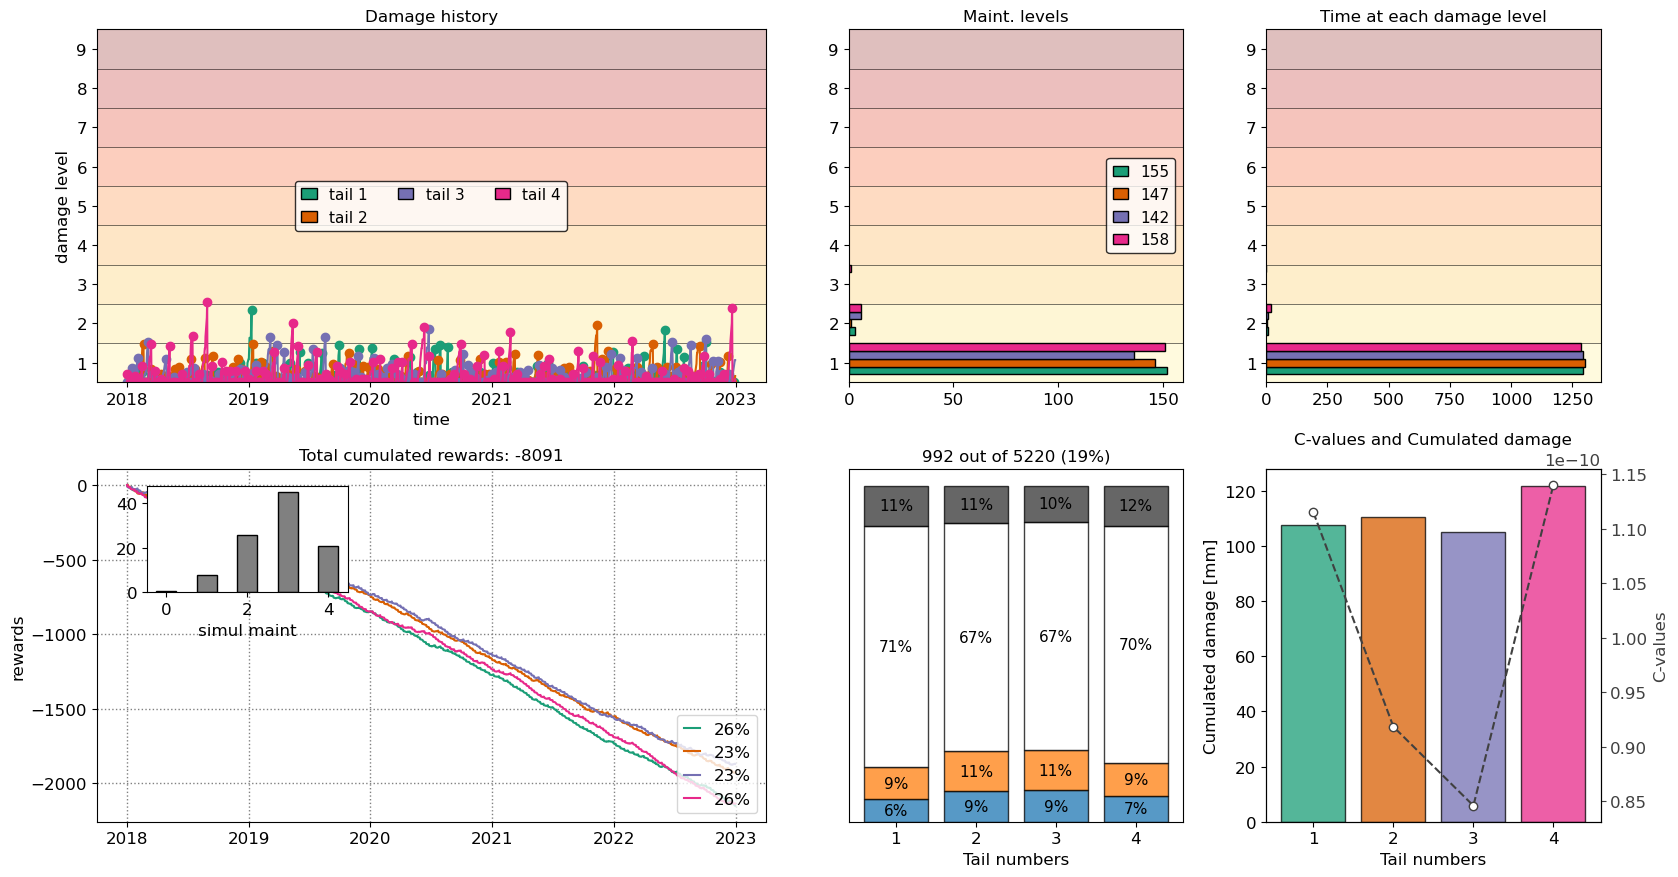

In [37]:
# random policy
env.reset()
damage_ts, reward_ts = opfleet.episode_random(env,plot_steps=False)
print('random -> total rewards = %d'%np.nansum(reward_ts))
fig1 = opfleet.plot_episode(damage_ts,reward_ts,env)

In the case of the random policy, preventive maintenance is used too often so the aircraft spend most of their time in maintenace and at low damage levels. Let's try the on-condition policy with a threshold at a damage level of 8.

on-condition -> total rewards = 3721


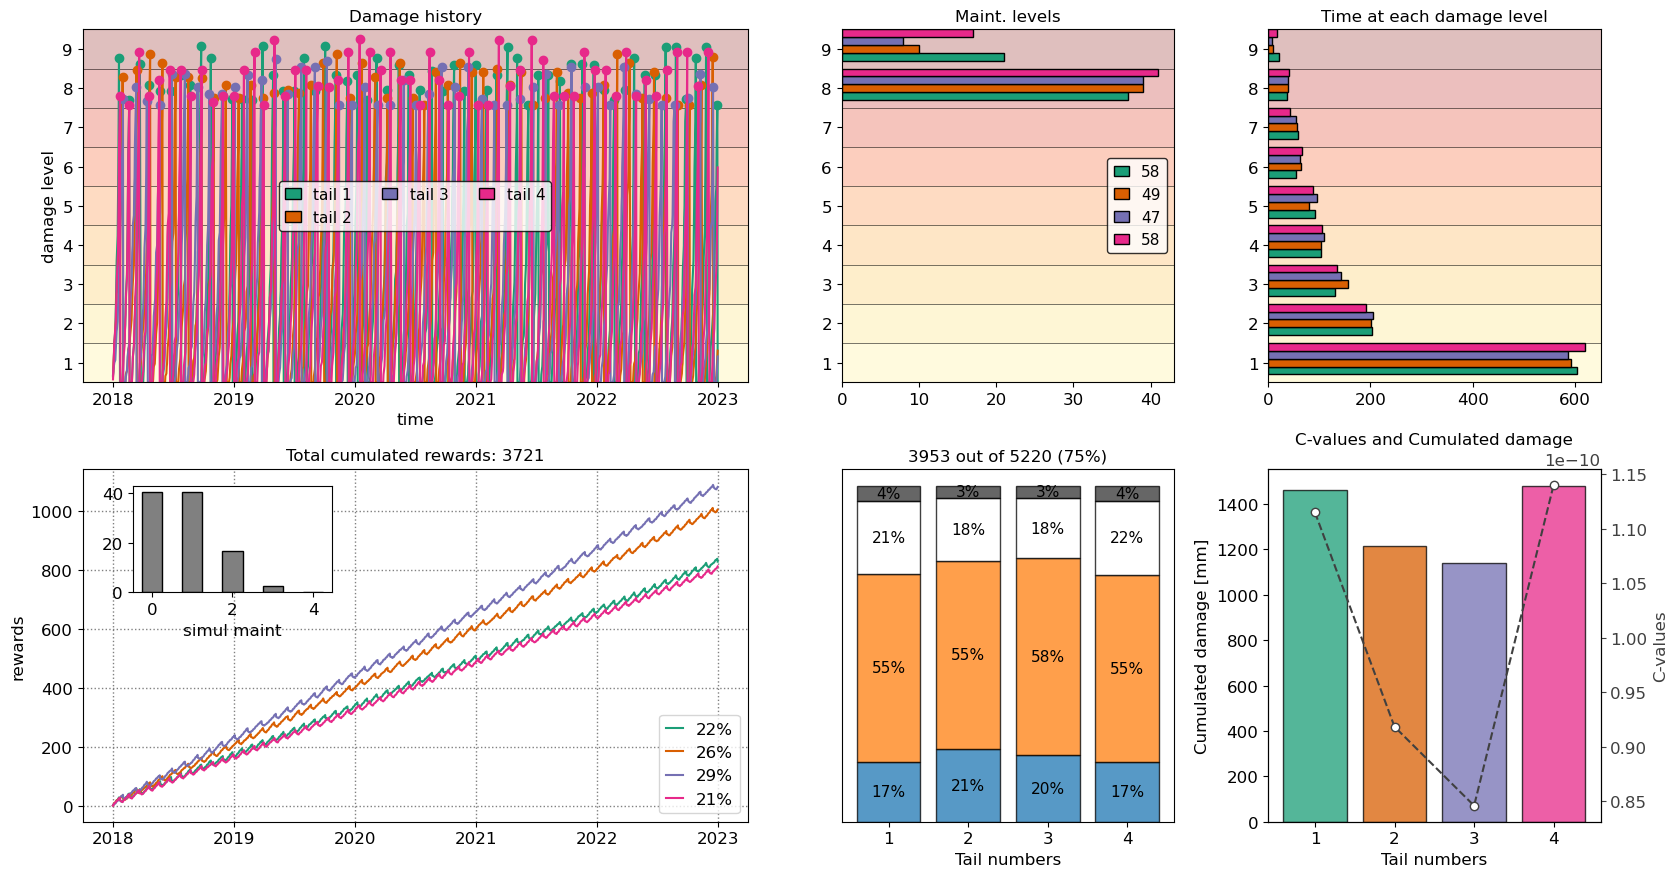

In [38]:
# run on-condition maintenance
env.reset()
damage_ts, reward_ts = opfleet.episode_on_condition(env,maint_level=8)
print('on-condition -> total rewards = %d'%np.nansum(reward_ts))
fig1 = opfleet.plot_episode(damage_ts,reward_ts,env)

The on-condition maintenance strategy performs much better as it manages to apply preventive maintenance at high damage levels while still avoid failure. But the mission assignment is random and not ideal, instead we can try force-life management to be a bit smarter about the mission assignment.

force-life -> total rewards = 3830


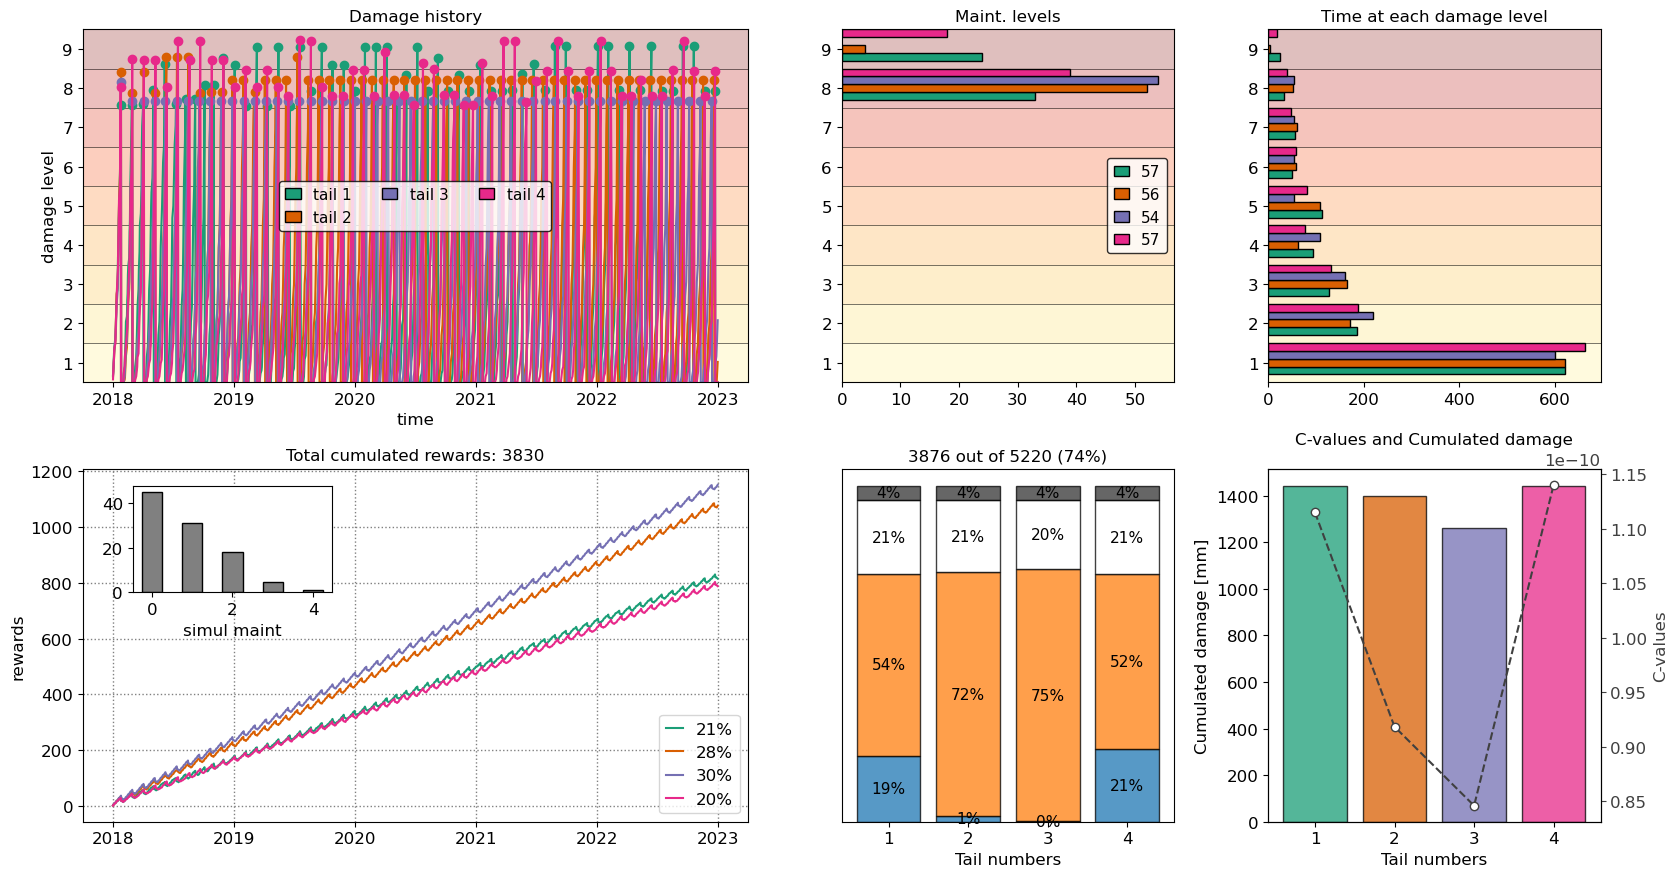

In [42]:
# run force-life management
env.reset()
damage_ts, reward_ts = opfleet.episode_force_life(env,maint_level=8)
print('force-life -> total rewards = %d'%np.nansum(reward_ts))
fig1 = opfleet.plot_episode(damage_ts,reward_ts,env)

We can see how this policy assigns the harder mission (M5) to the aircraft with the lower C-value, while the easier mission (M1) is always assigned to the aircraft with the higher C-value.

Finally, to evaluate the performance of any policy, one should not just run one episode as the total reward can depend on the initial conditions (damage level of each aircraft at timestep 0), but instead a large number of runs (1000 or 10,000) with varying initial conditions (sampled from a uniform distribution) need to be completed to obtain a distribution of rewards for each policy.

In [ ]:
# find optimal maintenance threshold for each policy
env = opfleet.Env(params)
repetitions = 10
maint_levels = np.arange(1,env.dlevels+1,dtype=int)
total_rewards_oncond = []
total_rewards_forcelife = []
total_rewards_equalstress = []
for i,level in enumerate(maint_levels):
    print('\r%d/%d'%(i,len(maint_levels)),end='')
    # optimise on-condition maintenance
    rewards = 0
    for k in range(repetitions):
        env.reset()
        env.crack_lengths = np.random.uniform(env.a0*1000,env.amax*1000,env.n_tail)
        damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
        env.state[:env.n_tail] = damage_levels
        damage_ts, reward_ts = opfleet.episode_on_condition(env,maint_level=level)
        rewards += np.nansum(reward_ts)
    total_rewards_oncond.append(rewards/repetitions)
    # optimise force-life management
    rewards = 0
    for k in range(repetitions):
        env.reset()
        env.crack_lengths = np.random.uniform(env.a0*1000,env.amax*1000,env.n_tail)
        damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
        env.state[:env.n_tail] = damage_levels
        damage_ts, reward_ts = opfleet.episode_force_life(env,maint_level=level)
        rewards += np.nansum(reward_ts)
    total_rewards_forcelife.append(rewards/repetitions)
    # optimise equal-stress management
    rewards = 0
    for k in range(repetitions):
        env.reset()
        env.crack_lengths = np.random.uniform(env.a0*1000,env.amax*1000,env.n_tail)
        damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
        env.state[:env.n_tail] = damage_levels
        damage_ts, reward_ts = opfleet.episode_equal_stress(env,maint_level=level)
        rewards += np.nansum(reward_ts)
    total_rewards_equalstress.append(rewards/repetitions) 
# plot optimisation results
fig,ax = plt.subplots(1,1,figsize=[10,5],tight_layout=True); 
ax.grid(which='major',ls=':',c='0.5',lw=0.5)
ax.plot(maint_levels,total_rewards_oncond,'-o',label='on-condition')
ax.plot(maint_levels,total_rewards_forcelife,'-o',label='force-life')
ax.plot(maint_levels,total_rewards_equalstress,'-o',label='equalstress')
ax.set(xlabel='maintenance level',ylabel='average reward')
ax.plot(maint_levels[np.argmax(total_rewards_oncond)],np.max(total_rewards_oncond),'C0o',mfc='None',ms=15)
ax.plot(maint_levels[np.argmax(total_rewards_forcelife)],np.max(total_rewards_forcelife),'C1o',mfc='None',ms=15)
ax.plot(maint_levels[np.argmax(total_rewards_equalstress)],np.max(total_rewards_equalstress),'C2o',mfc='None',ms=15)
ax.legend(loc='upper left')
maint_level_oncond = maint_levels[np.argmax(total_rewards_oncond)]
maint_level_forcelife = maint_levels[np.argmax(total_rewards_forcelife)]
maint_level_equalstress = maint_levels[np.argmax(total_rewards_equalstress)]
print('\nOptimum maintenance level for on-condition policy: damage level of %d'%maint_level_oncond)
print('Optimum maintenance level for force-life policy: damage level of %d'%maint_level_forcelife)
print('Optimum maintenance level for equal-stress policy: damage level of %d'%maint_level_equalstress)

In [ ]:
# run N simulations for each policy and compare the distributions
N = 1000
maint_level = 8
env = opfleet.Env(params)
# initialise variables
reward_random = np.empty((N,env.n_tail))
reward_on_condition = np.empty((N,env.n_tail))
reward_force_life = np.empty((N,env.n_tail))
reward_equal_stress = np.empty((N,env.n_tail))
completion_random = np.empty(N)
completion_on_condition = np.empty(N)
completion_force_life = np.empty(N)
completion_equal_stress = np.empty(N)
# randomly sample the initial crack lengths from a uniform distribution
crack_lengths = np.empty((N,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,N)
# run sinmuls
for i in range(N):
    print('\repisode %d/%d'%(i+1,N),end='')
    damage_levels = np.searchsorted(env.dintervals,crack_lengths[i,:],side='right')
    # on-condition maintenance
    env.reset()
    env.state[:env.n_tail] = copy.deepcopy(damage_levels)
    damage_ts, reward_ts = opfleet.episode_on_condition(env,maint_level=maint_level_oncond)
    reward_on_condition[i,:] = np.nansum(reward_ts,axis=0)
    # force-life management
    env.reset()
    env.state[:env.n_tail] = copy.deepcopy(damage_levels)
    damage_ts, reward_ts = opfleet.episode_force_life(env,maint_level=maint_level_forcelife)
    reward_force_life[i,:] = np.nansum(reward_ts,axis=0)
    # equal-stress policy
    env.reset()
    env.state[:env.n_tail] = copy.deepcopy(damage_levels)
    damage_ts, reward_ts = opfleet.episode_equal_stress(env,maint_level=maint_level_equalstress)
    reward_equal_stress[i,:] = np.nansum(reward_ts,axis=0)
# combine into dictionaries
reward_all = {'random':reward_random,
              'on_condition':reward_on_condition,
              'force_life':reward_force_life,
              'equal_stress':reward_equal_stress}

episode 148/1000

The we can plot the distribution of the rewards and compare the mean reward for each policy. However, from a risk management perspective, it's important to not only consider the average case but also the worst case scenarios, so we also plot the distribution of the runs below the 5th percentile.

In [ ]:
binwidth = 3
# plot full distributions
fig,axs=plt.subplots(2,1,figsize=[6,4],tight_layout=True,sharex=True); 
ax = axs[0]
ax.grid(which='major',ls=':',c='0.5',lw=0.5)
# plot each distribution
for i,key in enumerate(reward_all.keys()):
    if key in ['random']: continue
    rewards = np.sum(reward_all[key],axis=1)
    bins = np.arange(np.min(rewards)-50,np.max(rewards)+50+binwidth,binwidth)-binwidth/2
    ax.hist(rewards,bins=bins,fc='C%d'%i,ec='k',label='%s - mean = %d'%(key,np.mean(rewards)),alpha=0.5)
    ax.axvline(np.mean(rewards),ls='--',lw=2,c='C%d'%i) 
ax.legend(loc='upper left'); 
ax.set(title='Mission composition: %s - Reward: %s - %d runs'%(params['mission_composition'],params['reward_scheme'],len(rewards)),
       xlabel='total rewards',ylabel='counts');
ax.text(0,1.07,'a)',ha='left',va='top',transform=ax.transAxes,)
# fig.savefig(os.path.join(fp,'policy_comparison_%d.jpg'%idx_model),dpi=200)
ax.xaxis.set_tick_params(which='both', labelbottom=True)
# plot 5th percentile
ax = axs[1]
ax.grid(which='major',ls=':',c='0.5',lw=0.5)
# plot each distribution
for i,key in enumerate(reward_all.keys()):
    if key == 'random': continue
    rewards = np.sum(reward_all[key],axis=1)
    prc = np.percentile(rewards,5)
    rewards_prc = rewards[rewards <= prc]
    bins = np.arange(np.min(rewards_prc)-50,np.max(rewards_prc)+50+binwidth,binwidth)-binwidth/2
    ax.hist(rewards_prc,bins=bins,fc='C%d'%i,ec='k',label='%s - 5th prc = %d'%(key,prc),alpha=0.5)
    ax.axvline(prc,ls='--',lw=2,c='C%d'%i) 
ax.legend(loc='upper left'); 
ax.set(title='5th percentile of the distribution (worst case scenarios)',
       xlabel='total rewards',ylabel='counts');
ax.text(0,1.07,'b)',ha='left',va='top',transform=ax.transAxes,);

### 7. RL algorithms

Once the environment is setup, the goal is to find an optimal (or at least high-performing) policy using RL methods. 

So far, we have developed and tested a framework with Q-learning. The function that runs the Q-learning algorithm for the environment is `train_qtable(env,q_table,train_params)`. This method is used to optimise the environment for 3 different cases with fleets of 2, 3 and 4 aircraft respectively as shown in the Jupyter Notebooks (e.g., [fleet_optimisation_Qtable_2aircraft.ipynb](./fleet_optimisation_Qtable_2aircraft.ipynb))

There is also a framework to run Deep Q-learning (DQN), where the look-up table (Q-table) is replaced with a neural network as a function approximator. This is implemented in `train_DQNagent(env,q_table,train_params)`. This framework is harder to run as there are more hyper-parameters and without the right values for those parameters the policy may not converge. For instance, it is important to initialise the weights of the neural network before running the algorithm to help with convergence. This is covered in the Jupyter Notebook [fleet_optimisation_DQN_1aircraft.ipynb](./fleet_optimisation_DQN_1aircraft.ipynb]).

The main limitation of the Q-learning methods however, is that they cannot scale to larger fleets. Running the notebook with 4-aircraft takes about 2 weeks on a powerful machine (on CPU as it is sequential). As the state and action space increase exponentially with the number of aircraft in the fleet, there is a need to formulate the problem differently to avoid the combinatorial explosion. One way of overcoming this issue is to use **multi-agent RL**. Only initial progress has been done on the use of multi-agent RL:
1. Implement **Independent Q-learning (IQL)** where each agent is assigned an individual agent (Q-table) that learns independently. This can be used as a baseline and compared to the full Q-table examples in the Jupyter Notebooks. Started in [fleet_optimisation_IQL.ipynb](./fleet_optimisation_IQL.ipynb])
2. Add a cooperative behaviour to the IQL structure, for example a team reward using a Value Decomposition Network (VDN), as described in DeepMind's paper https://arxiv.org/abs/1706.05296.
